<a href="https://colab.research.google.com/github/seven320/-Target_on_with_Arduino/blob/master/EDA/V000_cal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import output
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:

import os
import math
import random
import re
import warnings
from pathlib import Path
from typing import Optional, Tuple
import time
import json
from contextlib import contextmanager
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

In [3]:
COMPE_NAME = "ventilatorPP"
BASE_DIR = f"/content/drive/MyDrive/kaggle/{COMPE_NAME}"

# NOTEBOOK_NAME = "V001-base"

In [4]:
# INPUTDIR = Path(os.path.join(BASE_DIR ,f"input"))

# SAVEDIR = Path(os.path.join(BASE_DIR ,f"models/{NOTEBOOK_NAME}"))
# SAVEDIR.mkdir(exist_ok=True, parents=True)

# OOFDIR = Path(os.path.join(BASE_DIR, f"oof/{NOTEBOOK_NAME}"))
# OOFDIR.mkdir(exist_ok=True, parents = True)

# SUBDIR = Path(os.path.join(BASE_DIR, f"submission/{NOTEBOOK_NAME}"))
# SUBDIR.mkdir(exist_ok=True, parents = True)

In [5]:
import glob, os, re

def convert_index_to_ENSEMBLE(indisies: list):
    oofs = glob.glob(f"/content/drive/MyDrive/kaggle/{COMPE_NAME}/oof/*")
    oofs = [os.path.basename(p) for p in oofs]
    #　Gxxxにひもづいた辞書を作成
    oof_index = {}
    for oof in oofs:
        oof_index[int(re.findall(r'\d+', oof)[0])] = oof

    ENSEMBLES = []
    for no in indisies:
        print(no)
        ENSEMBLES.append(oof_index[no])

    return ENSEMBLES

In [6]:
ensemble_nos = [27, 28, 34, 37]
ensemble_nos.sort()

ENSEMBLES = convert_index_to_ENSEMBLE(ensemble_nos)
print(ENSEMBLES)

27
28
34
37
['V027-V025-weight-leaning', 'V028-V027-weight-leaning01', 'V034-V030-model2', 'V037-V034-fold10']


In [23]:
def scoring_each_oof(ENSEMBLES: list):
    for i, ensemble in enumerate(ENSEMBLES):
        ensemble_path = Path(glob.glob(os.path.join(BASE_DIR, f"oof/{ensemble}", "oof*.csv"))[0])
        train_df = pd.read_csv(ensemble_path, usecols=["pressure", "u_out", "oof"])

        diff = abs(train_df["oof"] - train_df["pressure"])
        cv_score = diff.mean()

        mask = (train_df['u_out'] == -1).values
        valid_cv_score = diff[mask].mean()

        print(f"{ensemble[:4]} CV: {cv_score:.5f} valid_CV: {valid_cv_score:.5f}")

In [24]:
scoring_each_oof(ENSEMBLES)

V027 CV: 0.16184 valid_CV: 0.17273
V028 CV: 0.16244 valid_CV: 0.17124
V034 CV: 0.16122 valid_CV: 0.17053
V037 CV: 0.15669 valid_CV: 0.16215


In [25]:
ensemble_nos = [27, 28, 34, 37]
ensemble_nos.sort()

ENSEMBLES = convert_index_to_ENSEMBLE(ensemble_nos)
print(ENSEMBLES)

27
28
34
37
['V027-V025-weight-leaning', 'V028-V027-weight-leaning01', 'V034-V030-model2', 'V037-V034-fold10']


In [26]:
def scoring_averaging_oof(ENSEMBLES: list):
    ensemble_oof = None
    ensemble_true = None

    for i, ensemble in enumerate(ENSEMBLES):
        ensemble_path = Path(glob.glob(os.path.join(BASE_DIR, f"oof/{ensemble}", "oof*.csv"))[0])
        train_df = pd.read_csv(ensemble_path, usecols=["pressure", "u_out", "oof"])

        if ensemble_oof is None:
             ensemble_oof = np.zeros((len(ENSEMBLES), len(train_df)))
             ensemble_true = train_df["pressure"]
             mask = (train_df['u_out'] == -1).values
        ensemble_oof[i, :] = train_df["oof"]

    mean_oof = np.mean(ensemble_oof, axis = 0)

    diff = abs(mean_oof - ensemble_true)
    cv_score = diff.mean()
    valid_cv_score = diff[mask].mean()

    print(f"ensemble CV: {cv_score:.5f} valid_CV: {valid_cv_score:.5f}")

In [27]:
scoring_averaging_oof(ENSEMBLES)

ensemble CV: 0.14876 valid_CV: 0.15285


In [14]:
def scoring_each_oof(ENSEMBLES: list):
    for i, ensemble in enumerate(ENSEMBLES):
        ensemble_path = Path(glob.glob(os.path.join(BASE_DIR, f"oof/{ensemble}", "oof*.csv"))[0])
        train_df = pd.read_csv(ensemble_path, usecols=["pressure", "u_out", "oof"])

        diff = abs(train_df["oof"] - train_df["pressure"])
        cv_score = diff.mean()

        mask = (train_df['u_out'] == 0).values
        valid_cv_score = diff[mask].mean()

        print(f"{ensemble[:4]} CV: {cv_score:.5f} valid_CV: {valid_cv_score:.5f}")

In [47]:
ensemble = ENSEMBLES[0]
print(ensemble)

ensemble_path = Path(glob.glob(os.path.join(BASE_DIR, f"oof/{ensemble}", "oof*.csv"))[0])
train_df = pd.read_csv(ensemble_path)

V027-V025-weight-leaning


In [30]:
train_df.head(10)

,id,breath_id,R,C,time_step,u_in,u_out,pressure,fold,time_delta,delta,area,cross,cross2,u_in_cumsum,u_in_cummean,u_in_lag_1,u_in_time1,u_out_lag_1,u_in_lag_2,u_in_time2,u_out_lag_2,u_in_lag_3,u_in_time3,u_out_lag_3,u_in_lag_4,u_in_time4,u_out_lag_4,breath_time,C_cate,R_cate,RC_sum,RC_dot,oof
0,1,1,20,50,-0.989105,-0.938051,-1.0,5.837492,4.0,0.000000,0.000000,-0.734147,0.0,-0.66557,-0.724032,-0.647256,-0.864294,0.472113,-1.0,-0.841938,0.218070,-1.0,-0.818664,0.121100,-1.0,-0.793497,0.068265,-1.0,-15.407460,2,1,6,7,5.767190
1,2,1,20,50,-0.963659,3.054611,-1.0,5.907794,4.0,0.033652,0.618632,-0.682712,0.0,-0.66557,-0.675685,0.162870,-0.847520,113.649156,-1.0,-0.841938,58.785756,-1.0,-0.818664,38.106145,-1.0,-0.793497,26.285903,-1.0,0.077784,2,1,6,7,5.907794
2,3,1,20,50,-0.938055,3.954880,-1.0,7.876254,4.0,0.033862,0.762212,-0.619338,0.0,-0.66557,-0.616486,0.554690,2.835938,25.590379,-1.0,-0.825195,71.724949,-1.0,-0.818664,46.671050,-1.0,-0.793497,32.197482,-1.0,15.659572,2,1,6,7,7.946556
3,4,1,20,50,-0.912325,4.020235,-1.0,11.742872,4.0,0.034028,0.776134,-0.554806,0.0,-0.66557,-0.556499,0.757231,3.666488,1.815413,-1.0,2.851513,14.115946,-1.0,-0.801907,47.119843,-1.0,-0.793497,32.626634,-1.0,31.317608,2,1,6,7,11.813174
4,5,1,20,50,-0.886455,4.575950,-1.0,12.234987,4.0,0.034213,0.867507,-0.482678,0.0,-0.66557,-0.489813,0.923858,3.726782,15.778870,-1.0,3.680541,9.061736,-1.0,2.877892,14.421712,-1.0,-0.776723,36.156321,-1.0,0.335930,2,1,6,7,12.516195
5,6,1,20,50,-0.860790,4.991371,-1.0,12.867706,4.0,0.033942,0.925260,-0.405747,0.0,-0.66557,-0.418120,1.063039,4.239460,11.783879,-1.0,3.740724,14.196799,-1.0,3.707617,9.809007,-1.0,2.906733,12.666529,-1.0,0.211190,2,1,6,7,13.008310
6,7,1,20,50,-0.835074,4.962488,-1.0,14.695562,4.0,0.034010,0.922610,-0.329037,0.0,-0.66557,-0.346775,1.160780,4.622710,-0.868105,-1.0,4.252464,5.621430,-1.0,3.767851,8.912452,-1.0,3.737282,6.565291,-1.0,0.242457,2,1,6,7,14.976770
7,8,1,20,50,-0.809354,4.892724,-1.0,15.890699,4.0,0.034015,0.911857,-0.253221,0.0,-0.66557,-0.276271,1.230547,4.596064,-2.032244,-1.0,4.635011,-1.495680,-1.0,4.280021,2.961820,-1.0,3.797576,5.678034,-1.0,0.244542,2,1,6,7,16.171907
8,9,1,20,50,-0.783605,5.123338,-1.0,15.539188,4.0,0.034054,0.948900,-0.174325,0.0,-0.66557,-0.202988,1.295209,4.531703,6.521329,-1.0,4.608414,2.310845,-1.0,4.662890,1.203620,-1.0,4.310255,3.543277,-1.0,0.262534,2,1,6,7,15.609490
9,10,1,20,50,-0.757930,5.221153,-1.0,15.750094,4.0,0.033955,0.961379,-0.094392,0.0,-0.66557,-0.128525,1.350907,4.744458,2.739747,-1.0,4.544170,4.769044,-1.0,4.636270,2.408991,-1.0,4.693504,1.457730,-1.0,0.217224,2,1,6,7,15.890698


In [62]:
 # [x]R,Cごとのバイアスが存在するのか→バイアス計算●
 # [x]差分が大きい時間やグループが存在するか→かしか●
 # [ ]foldが違うことによる差分は何か？→フォールドごとの差分を検証(まだ)

# バイアスは少し乗ってるサンプルがありそう。乗っているとmask部分が全体よりもスコアが悪い→バイアスをこちらで解消できないか？(ルールがある？)


In [75]:

train_df["diff"] = train_df["oof"] - train_df["pressure"]

# バイアス調査
Rs = train_df["R"].unique()
Cs = train_df["C"].unique()

for r in Rs:
    for c in Cs:
        print(r, c)
        print(f"sample cnt: {sum((train_df.R == r) & (train_df.C == c))}")
        print(train_df[(train_df.R == r) & (train_df.C == c)]["diff"].mean())

20 50
sample cnt: 654880
-0.003142457782578926
20 20
sample cnt: 496640
0.0008264349921819324
20 10
sample cnt: 485600
0.0021370386211284225
50 50
sample cnt: 655120
-0.0025617143723484803
50 20
sample cnt: 660800
0.004442543830735458
50 10
sample cnt: 1094160
0.001032948567532938
5 50
sample cnt: 661680
-0.02127049530878205
5 20
sample cnt: 662160
-0.006420762984150461
5 10
sample cnt: 664960
-0.00018879213892101783


In [117]:
def show_diff(sample_id: int):

    # 全体
    sample = train_df[train_df["breath_id"] == sample_id]
    mask_sample = sample[sample.u_out == -1]

    if sample['diff'].abs().mean() < mask_sample['diff'].abs().mean():
        plt.plot(sample.pressure, label = "pressure")
        plt.plot(sample.oof, label = "oof")
        plt.legend()
        plt.plot(sample.u_out)
        plt.plot(sample["diff"])

        plt.show()

        # CV有効部分のみ
        plt.plot(mask_sample.pressure, label = "pressure")
        plt.plot(mask_sample.oof, label = "oof")
        plt.legend()
        plt.plot(mask_sample["diff"])
        plt.show()
        print(f"all_score: {sample['diff'].abs().mean():.4f}, mask_score: {mask_sample['diff'].abs().mean():.4f}")

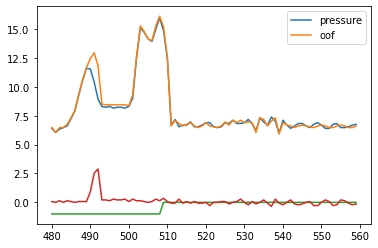

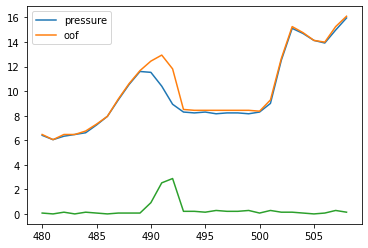

all_score: 0.2048, mask_score: 0.3345


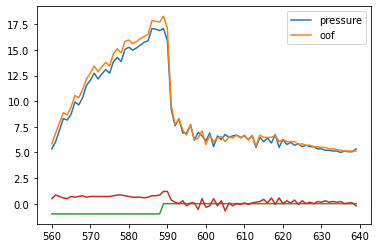

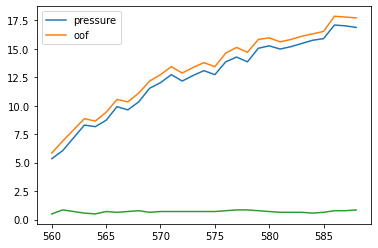

all_score: 0.4060, mask_score: 0.6957


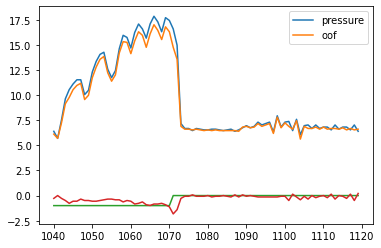

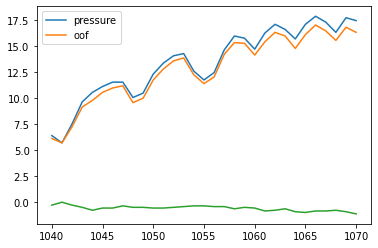

all_score: 0.3480, mask_score: 0.5874


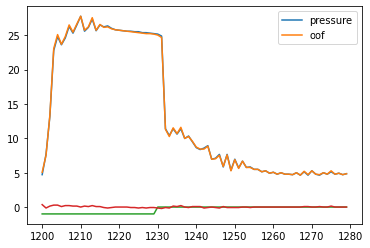

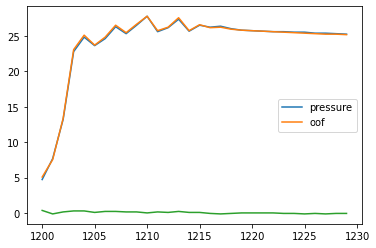

all_score: 0.0738, mask_score: 0.1148


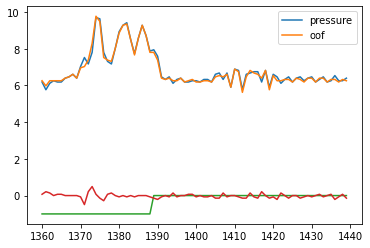

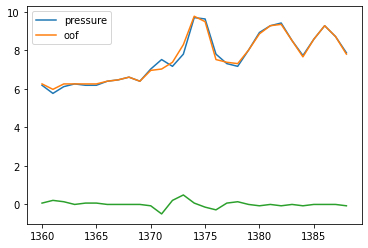

all_score: 0.0870, mask_score: 0.0970


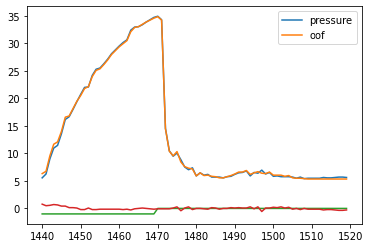

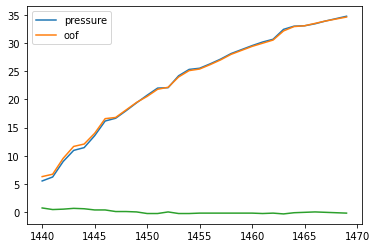

all_score: 0.1863, mask_score: 0.2367


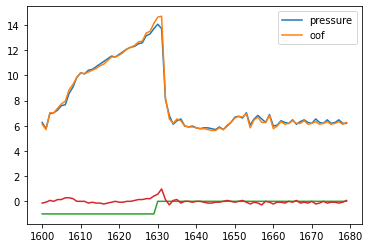

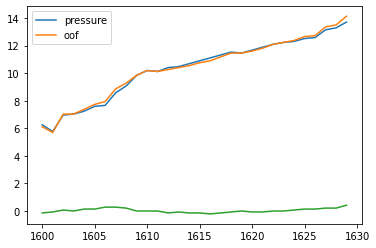

all_score: 0.1178, mask_score: 0.1195


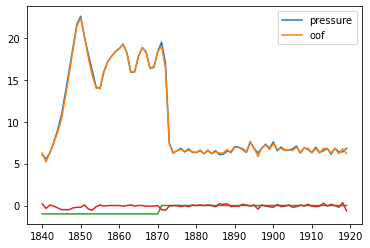

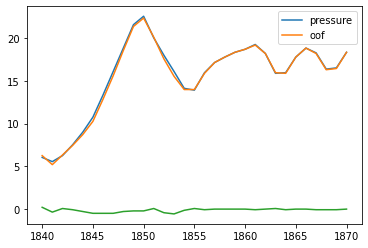

all_score: 0.1476, mask_score: 0.1587


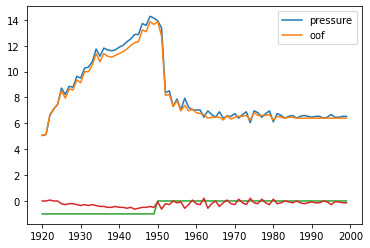

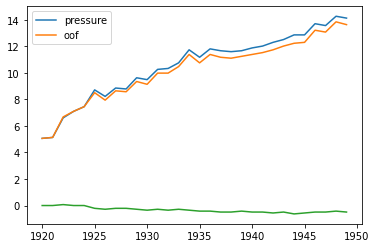

all_score: 0.2399, mask_score: 0.3421


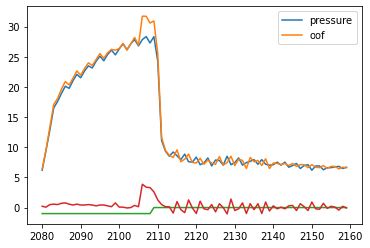

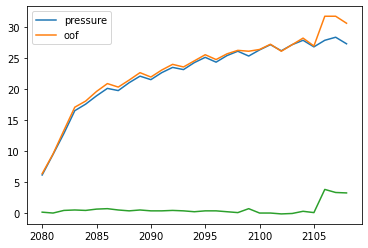

all_score: 0.6134, mask_score: 0.6957


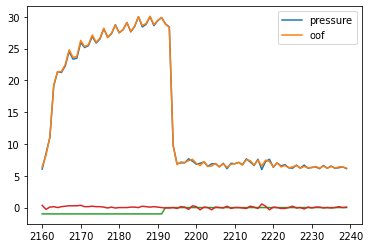

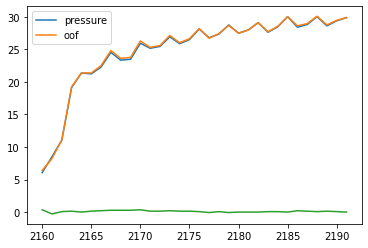

all_score: 0.1239, mask_score: 0.1318


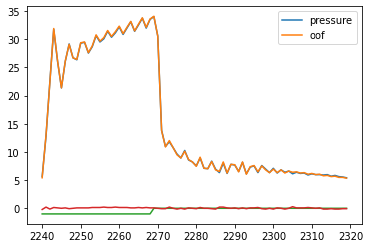

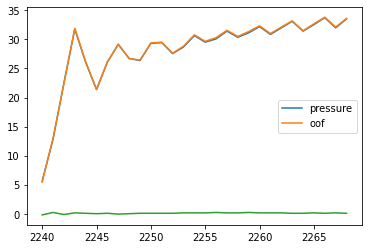

all_score: 0.0958, mask_score: 0.1139


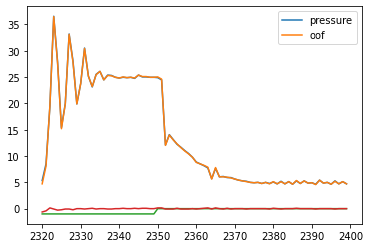

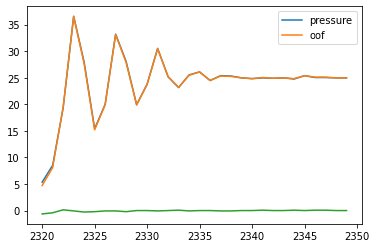

all_score: 0.0589, mask_score: 0.0914


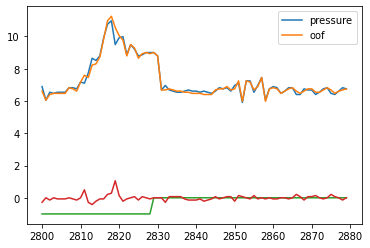

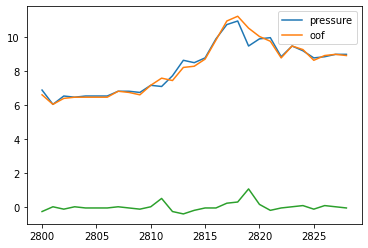

all_score: 0.1090, mask_score: 0.1624


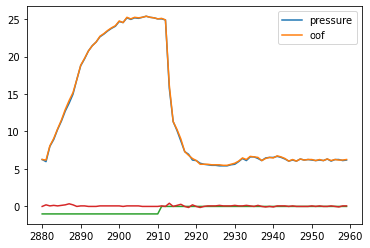

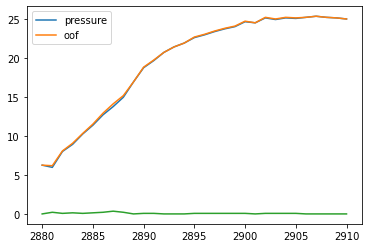

all_score: 0.0712, mask_score: 0.0726


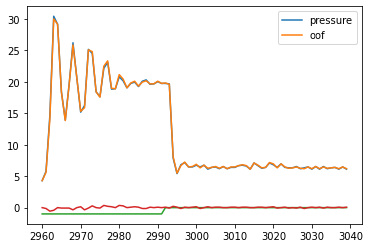

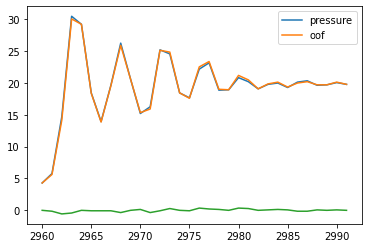

all_score: 0.0932, mask_score: 0.1450


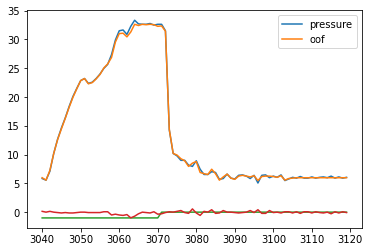

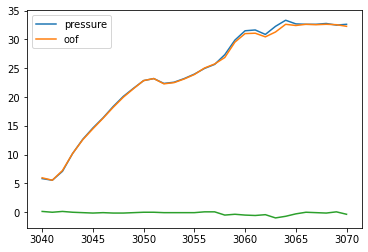

all_score: 0.1696, mask_score: 0.2018


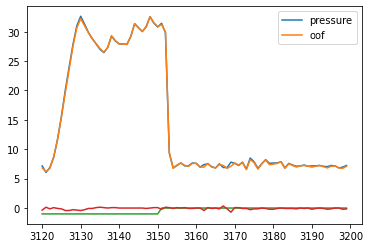

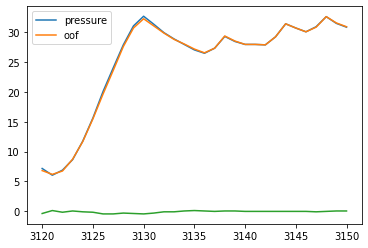

all_score: 0.1178, mask_score: 0.1247


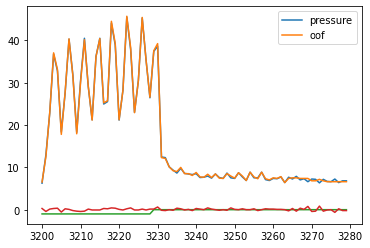

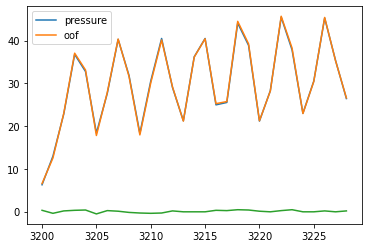

all_score: 0.2144, mask_score: 0.2255


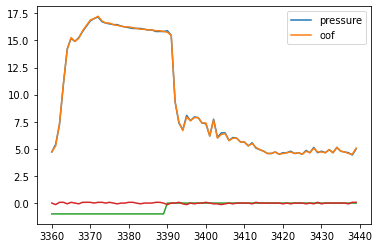

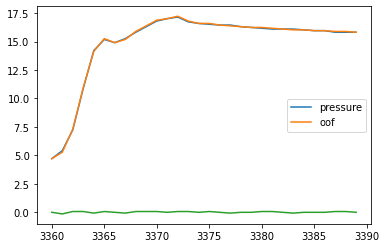

all_score: 0.0387, mask_score: 0.0445


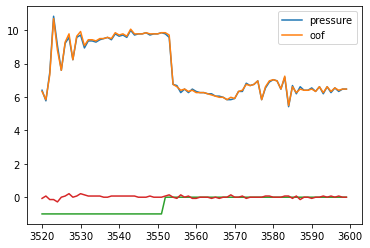

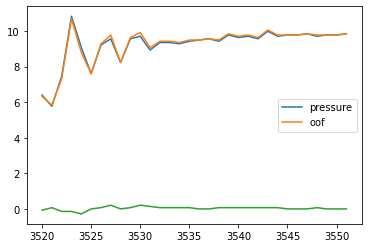

all_score: 0.0518, mask_score: 0.0703


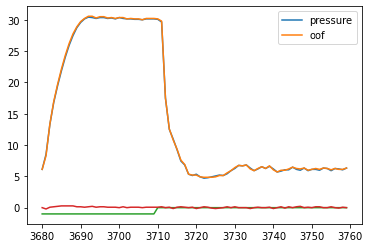

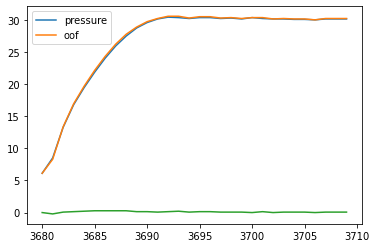

all_score: 0.0879, mask_score: 0.1195


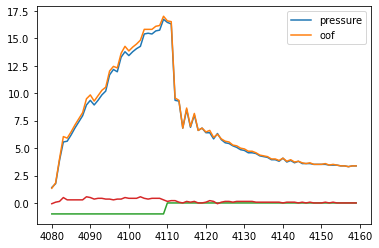

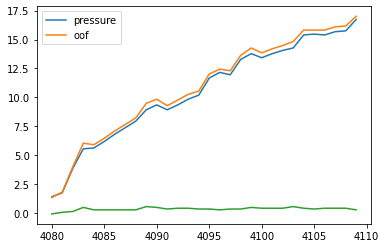

all_score: 0.1793, mask_score: 0.3585


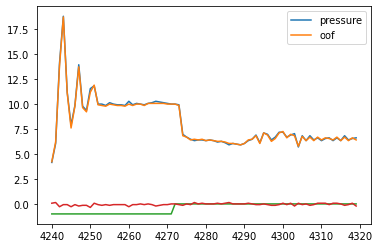

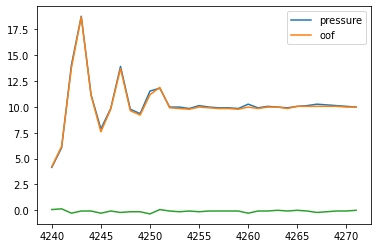

all_score: 0.0844, mask_score: 0.1142


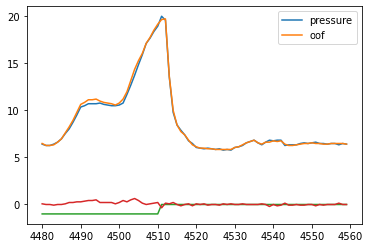

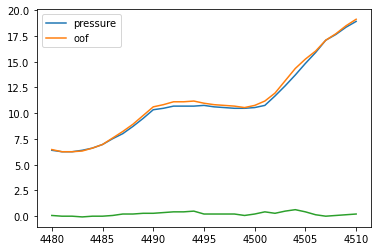

all_score: 0.1213, mask_score: 0.2200


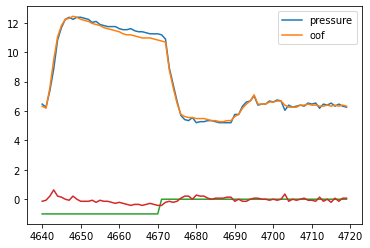

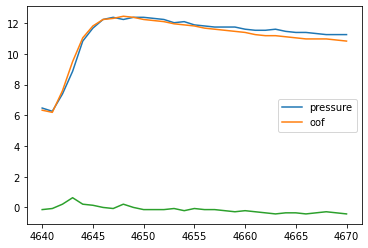

all_score: 0.1547, mask_score: 0.2268


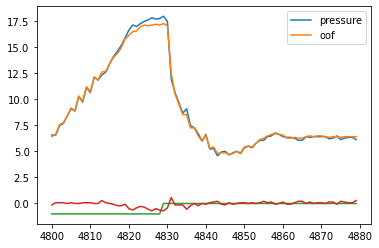

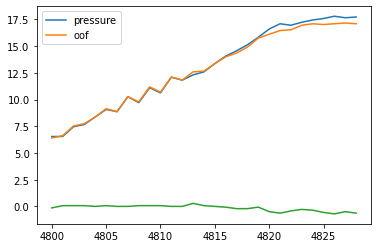

all_score: 0.1626, mask_score: 0.2109


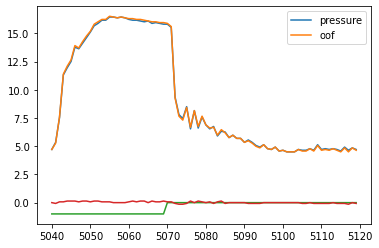

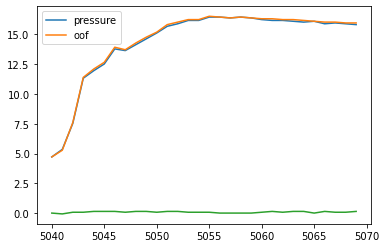

all_score: 0.0633, mask_score: 0.0844


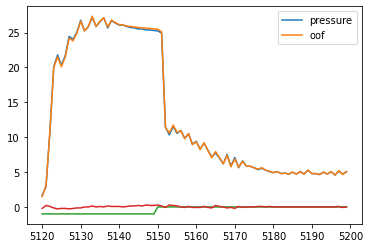

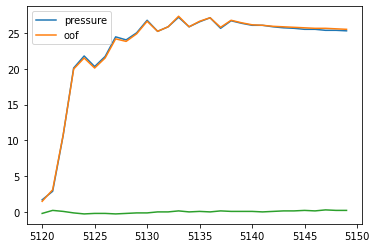

all_score: 0.0879, mask_score: 0.1359


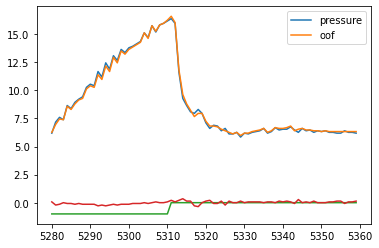

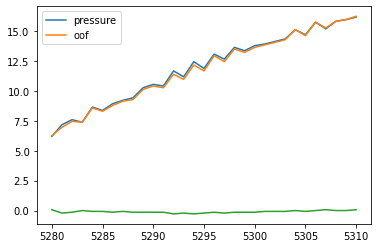

all_score: 0.1072, mask_score: 0.1134


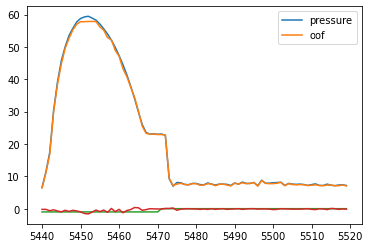

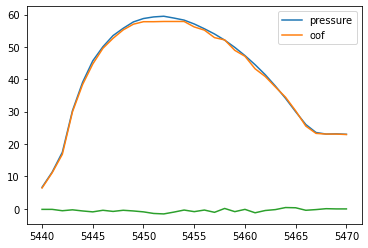

all_score: 0.3023, mask_score: 0.5964


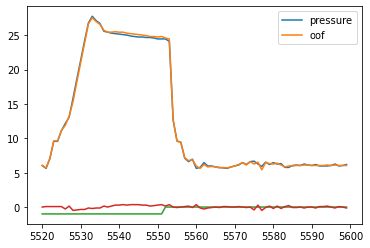

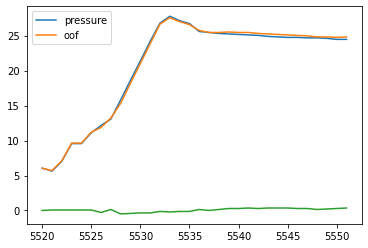

all_score: 0.1573, mask_score: 0.2219


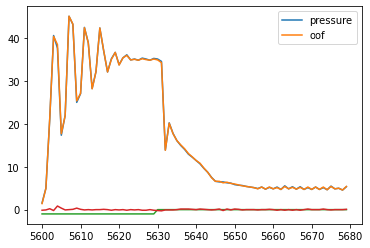

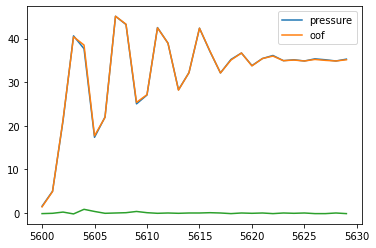

all_score: 0.0861, mask_score: 0.1148


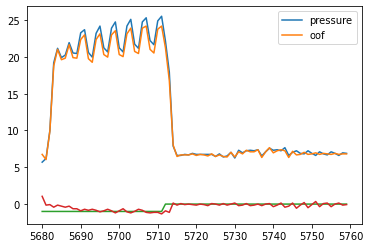

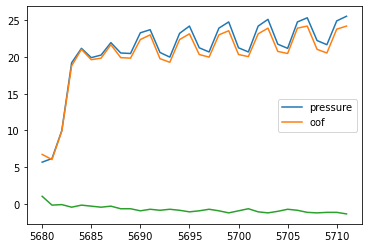

all_score: 0.4280, mask_score: 0.7843


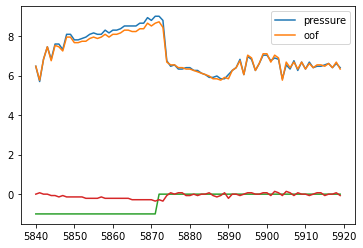

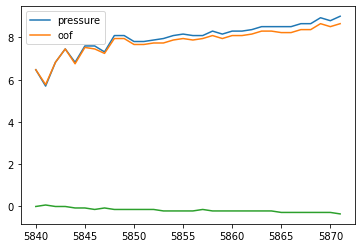

all_score: 0.1107, mask_score: 0.1758


In [118]:
for sample_id in range(1, 100):
    show_diff(sample_id)

0.24166372402699662